In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2 as cv
import imageio
import pyMRAW
import scipy as sp
import pyidi
import copy
import os

from typing import Union

%load_ext autoreload
%autoreload 2
%matplotlib inline

c:\Users\kristofc\Doktorat\Projekti\pyidi\.venv\Lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 150000, Original total frame: 621319)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


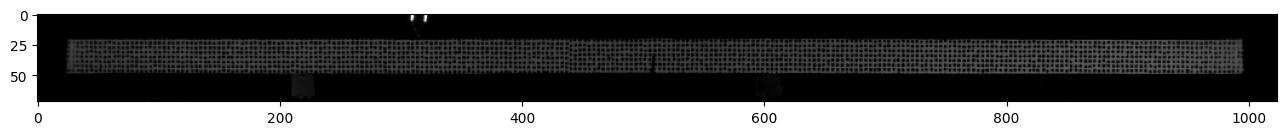

In [2]:
file = "C:\\Users\\kristofc\\Doktorat\\Podatki\\20201011_Nosilec_zareza_speckle\\video_001.cihx"

video = pyMRAW.load_video(file)
cih = video[1]
cih

plt.rcParams['figure.figsize'] = (16,6)

fig = video[0][0]#[:150000,:,25:995]

plt.imshow(fig, 'gray')

In [3]:
vect_0 = np.loadtxt("C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek I\\Python Nosilec\\vect_0.txt")
vect_1 = np.loadtxt("C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek I\\Python Nosilec\\vect_1.txt")
coord  = np.loadtxt("C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek I\\Python Nosilec\\coord.txt")

# coord[:,[0,1]] = coord[:,[1,0]]

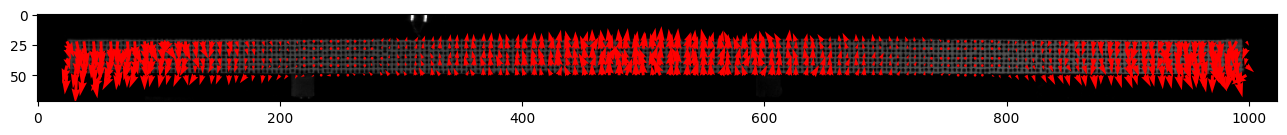

In [4]:
mode_0 = vect_0[0,:]
mode_1 = vect_1[0,:]

disp = np.column_stack((mode_0, mode_1))

plt.imshow(fig, 'gray')
# plt.scatter(coord[:,1], coord[:,0])
plt.quiver(coord[:,1], coord[:,0], mode_1, mode_0, color = 'r', scale = 1.1)

In [7]:
vid = pyidi.pyIDI(file)
vid.set_points(points=coord)

res = pyidi.postprocessing.motion_magnification(video=vid, 
                                                disp=disp, 
                                                mag_fact=5000)

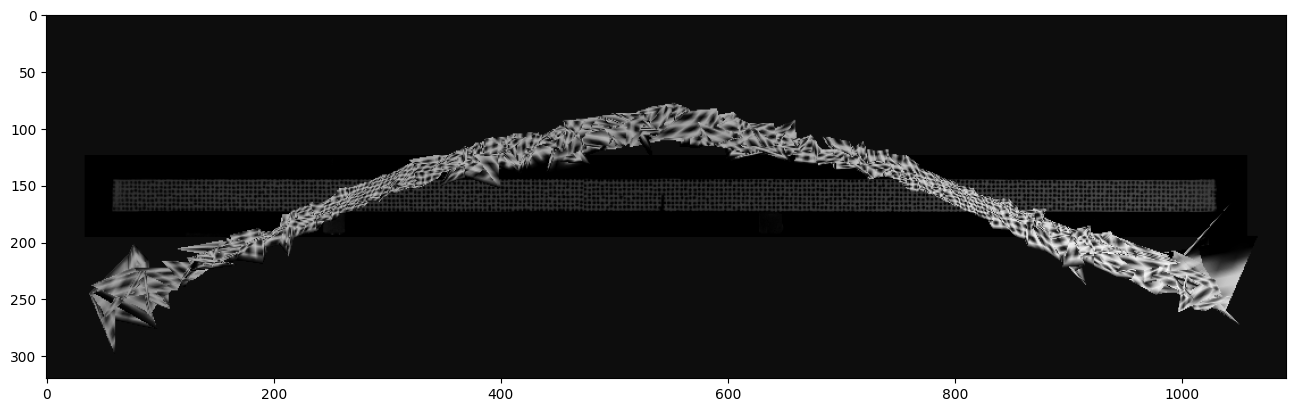

In [8]:
plt.imshow(res, 'gray')

In [11]:
pyidi.postprocessing.animate(video = vid,
                             disp = disp,
                             mag_fact = 500,
                             fps = 60,
                             n_periods = 1,
                             filename='c:/Users/kristofc/Doktorat/Projekti/my_folder/my_video')

Video saved in file: c:/Users/kristofc/Doktorat/Projekti/my_folder/my_video.mp4


In [8]:
def create_mesh(points, disp, mag_fact):
    """
    Generates a planar mesh of triangles based on the input set of points. Then 
    generates the deformed planar mesh of triangles based on the displacement 
    vectors "disp", scaled by the magnification factor "mag_fact".
    """

    # Switch x and y columns
    pts = np.column_stack((points[:,0], 
                           points[:,1]))
    
    # Create undeformed mesh
    mesh = sp.spatial.Delaunay(pts)

    # Create deformed mesh
    # The coordinates of the original mesh are over-written with their counter-
    # parts in the warped mesh, while the triangle connectivity of the original
    # mesh is retained.
    mesh_def = copy.deepcopy(mesh)
    mesh_def.points[:, 0] = mesh.points[:, 0] - disp[:, 0] * mag_fact
    mesh_def.points[:, 1] = mesh.points[:, 1] + disp[:, 1] * mag_fact

    return mesh, mesh_def

In [54]:
mesh, mesh_def = create_mesh(points = coord,
                             disp = disp,
                             mag_fact = 5000)

mesh_def_negative = create_mesh(points = coord,
                                disp = disp,
                                mag_fact = -5000)[1]

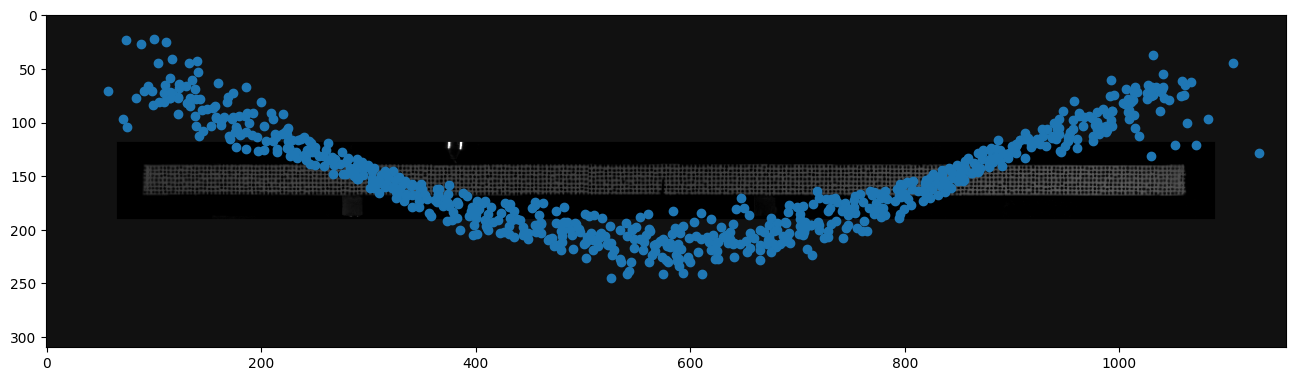

In [53]:
def init_output_image(input_image, mesh, mesh_def):
    """
    Initialze the output image. The output image needs to be large enough to 
    prevent clipping of the motion magnified shape.
    """
    d = np.array([
          np.min(mesh[:, 1]) - np.min(mesh_def[:, 1]),
        - np.max(mesh[:, 1]) + np.max(mesh_def[:, 1]),
          np.min(mesh[:, 0]) - np.min(mesh_def[:, 0]),
        - np.max(mesh[:, 0]) + np.max(mesh_def[:, 0])
    ])
    d = np.round(d).astype('int')

    a = np.max(np.abs([d[2], d[3]]))
    b = np.max(np.abs([d[0], d[1]]))

    val = np.average(input_image) * 0.3

    out = cv.copyMakeBorder(input_image * 0.3,
                            top = a,
                            bottom = a,
                            left = b,
                            right = b,
                            borderType = cv.BORDER_CONSTANT,
                            value = val)
    return out, a, b

out, a, b = init_output_image(input_image = vid.mraw[0],
                              mesh = mesh.points,
                              mesh_def = mesh_def.points)

plt.imshow(out, 'gray')
plt.scatter(mesh_def.points[:, 1] + b,
            mesh_def.points[:, 0] + a)

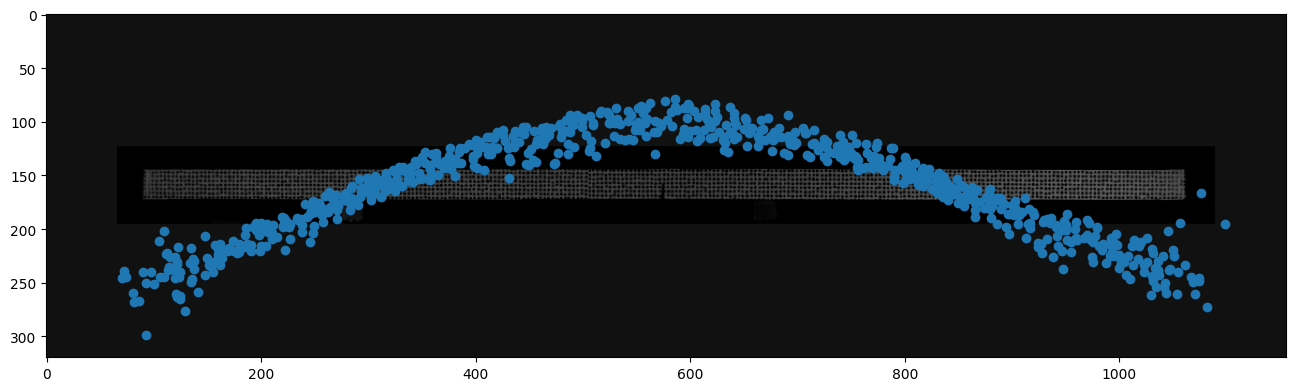

In [61]:
out, a, b = init_output_image(input_image = vid.mraw[0],
                              mesh = mesh.points,
                              mesh_def = np.concatenate((mesh_def.points, mesh_def_negative.points)))

plt.imshow(out, 'gray')
plt.scatter(mesh_def.points[:, 1] + b,
            mesh_def.points[:, 0] + a)

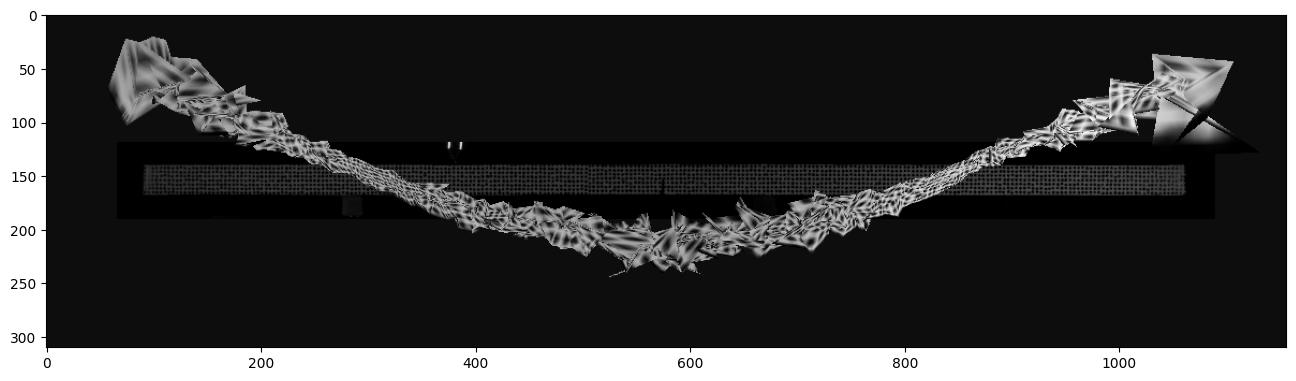

In [51]:
def warp_image_elements(img_in, img_out, mesh, mesh_def, a, b):
    """
    Warp image elements based on mesh and deformed mesh nodes.
    """

    for i in range(len(mesh.simplices)):
        el_0 = np.float32(mesh.points[mesh.simplices[i]])
        el_1 = np.float32(mesh_def.points[mesh.simplices[i]])

        # Define axis-aligned bounding rectangle for given triangle element in 
        # its original and deformed state
        rect_0 = cv.boundingRect(el_0)
        rect_1 = cv.boundingRect(el_1)

        reg_0 = [((el_0[j, 1] - rect_0[1]), 
                  (el_0[j, 0] - rect_0[0])) 
                    for j in range(3)]

        reg_1 = [((el_1[j, 1] - rect_1[1]),
                  (el_1[j, 0] - rect_1[0])) 
                    for j in range(3)]

        crop_0 = img_in[rect_0[0] : rect_0[0] + rect_0[2],
                        rect_0[1] : rect_0[1] + rect_0[3]]

        # Definition of the affine transformation matrix for the given triangle 
        # element
        aff_mat = cv.getAffineTransform(
            src = np.float32(reg_0),
            dst = np.float32(reg_1)
        )

        # Execution of the affine transformation
        crop_1 = cv.warpAffine(
            src = crop_0,
            M = aff_mat,
            dsize = (rect_1[3], rect_1[2]),
            dst = None,
            flags = cv.INTER_LINEAR,
            borderMode = cv.BORDER_REFLECT_101,
        )

        mask = np.zeros((rect_1[2], rect_1[3]), dtype=np.float32)
        mask = cv.fillConvexPoly(
            img = mask,
            points = np.int32(reg_1),
            color = 1,
            lineType = cv.LINE_AA,
            shift=0
        )

        # Assembly of the transformed element into the output image
        img_out[
            rect_1[0] + a : rect_1[0] + rect_1[2] + a,
            rect_1[1] + b : rect_1[1] + rect_1[3] + b
        ] = img_out[
            rect_1[0] + a : rect_1[0] + rect_1[2] + a,
            rect_1[1] + b : rect_1[1] + rect_1[3] + b
        ] * (1.0 - mask) + crop_1 * mask

    return img_out

img_out = warp_image_elements(img_in = vid.mraw[0], 
                              img_out = out,
                              mesh = mesh,
                              mesh_def = mesh_def,
                              a = a,
                              b = b
                              )

plt.imshow(img_out, 'gray')

In [52]:
def animate(disp: np.ndarray, 
            mag_fact: Union[int, float], 
            video = None, 
            img: Union[np.ndarray, np.memmap] = None, 
            pts: np.ndarray = None,
            fps: int = 30,
            n_periods: int = 3,
            filename: str = 'Motion_mag_video'
            )-> None:
    """
    Create a video based on the Experimental modal analysis motion magnification. 
    If a 'pyidi.pyIDI class instance is input as argument 'video', the argument 
    'img' is set to 'video.mraw[0]' and the argument 'pts' is set to 'video.points'. 
    These values can be overwritten by specifying the 'img' and 'pts' arguments 
    explicitly.

    :param disp: displacement vector
    :type disp: numpy.ndarray
    :param mag_fact: magnification factor
    :type mag_fact: int or float
    :param video: pyIDI class instance, 
        defaults to None
    :type video: pyidi.pyIDI or None, optional
    :param img: the reference image, on which motion magnification is performed,
        defaults to None
    :type img: numpy.ndarray, numpy.memmap or None, optional
    :param pts: image coordinates, where displacements 'disp' are defined,
        defaults to None
    :type pts: numpy.ndarray or None, optional
    :param fps: framerate of the created video, 
        defaults to 30
    :type fps: int, optional
    :param n_periods: number of periods of oscilation to be animated,
        defaults to 3
    :type n_periods: int, optional
    :param filename: the name of the output video file
        defaults to 'Motion_mag_video'
    :type filename: str
    """
    if hasattr(disp, 'shape') and len(disp.shape) == 2:
        pass
    else:
        raise TypeError("The expected data type for argument 'disp' is a 2D "\
                        "array of image coordinates of points of interest.")
    
    if isinstance(mag_fact, (int, float)):
        pass
    else:
        raise TypeError("Expected data type for argument 'mag_fact' is int or "\
                        "float.")
    
    if isinstance(fps, int):
        pass
    else:
        raise TypeError("Expected data type for argument 'fps' is int.")
    
    if isinstance(n_periods, int):
        pass
    else:
        raise TypeError("Expected data type for argument 'n_periods' is int.")
    
    if isinstance(filename, str):
        pass
    else:
        raise TypeError("Expected data type for argument 'filename' is str.")
    
    if video is not None:
        if img is not None:
            if isinstance(img, (np.ndarray, np.memmap)):
                img_in = img
            else:
                raise TypeError("Expected object types for argument 'img' are "\
                                "'numpy.ndarray' and 'numpy.memmap'.")
        else:
            img_in = video.mraw[0]

        if pts is not None:
            if isinstance(pts, np.ndarray):
                points = pts
            else:
                raise TypeError("Expected object type for argument 'pts' is "\
                                "'numpy.ndarray'.")
        else:
            points = video.points

    elif img is not None and pts is not None:
        if isinstance(img, (np.ndarray, np.memmap)):
            img_in = img
        else:
            raise TypeError("Expected object types for argument 'img' are "\
                            "'numpy.ndarray' and 'numpy.memmap'.")

        if isinstance(pts, np.ndarray):
            points = pts
        else:
            raise TypeError("Expected object type for argument 'pts' is "\
                            "'numpy.ndarray'.")
    
    else:
        raise TypeError("Both the input image and the points of interest need "\
                        "to be input, either via 'video' attributes 'mraw' and"\
                        " 'points' or as seperate arguments 'img' and 'pts'.")
    
    # Create subfolder defined in 'filename' argument (if needed)
    folder, name = os.path.split(filename)
    if folder and not os.path.exists(folder):
        os.makedirs(folder)
    
    mesh, mesh_def = create_mesh(points = points,
                                 disp = disp,
                                 mag_fact = mag_fact)
    
    # All frames of the output video are the same size, defined by the maximum
    # deflections
    img_out, a, b = init_output_image(input_image = img_in,
                                      mesh = mesh,
                                      mesh_def = mesh_def)
    
    return img_out

res = animate(video = vid,
              disp = disp,
              mag_fact = -5000,
              fps = 60,
              n_periods = 1,
              filename='c:/Users/kristofc/Doktorat/Projekti/my_folder/my_video')

In [31]:
res.shape

(310, 1156)

In [29]:
img_out.shape

(310, 1156)